Using Crocs from Yahoo Finance, implement several classical statistics time series forecasting.

Prerequisites: Load Libraries

In [27]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Step 1: Download Crocs stock data

In [2]:
data = yf.download('CROX', start = "2020-01-01", end = "2023-01-01")
data.head(10)

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,CROX,CROX,CROX,CROX,CROX,CROX
Date,,,,,,
2020-01-02 00:00:00+00:00,41.750000,41.750000,42.230000,41.259998,42.230000,1024300
2020-01-03 00:00:00+00:00,42.080002,42.080002,42.139999,41.160000,41.310001,662800
2020-01-06 00:00:00+00:00,42.410000,42.410000,42.590000,41.529999,41.970001,824200
2020-01-07 00:00:00+00:00,41.610001,41.610001,42.810001,41.430000,42.509998,1127500
2020-01-08 00:00:00+00:00,42.680000,42.680000,43.310001,41.500000,41.639999,1420800
2020-01-09 00:00:00+00:00,43.400002,43.400002,43.430000,42.580002,42.799999,1067700
2020-01-10 00:00:00+00:00,42.889999,42.889999,43.580002,42.389999,43.279999,1477500
2020-01-13 00:00:00+00:00,42.230000,42.230000,43.040001,40.520000,43.040001,1961900


Step 2: Extract Adjusted Close Price

In [3]:
crox_data = data['Adj Close']
crox_data.head()

Ticker,CROX
Date,
2020-01-02 00:00:00+00:00,41.750000
2020-01-03 00:00:00+00:00,42.080002
2020-01-06 00:00:00+00:00,42.410000
2020-01-07 00:00:00+00:00,41.610001
2020-01-08 00:00:00+00:00,42.680000


Step 3: Visualize the Data

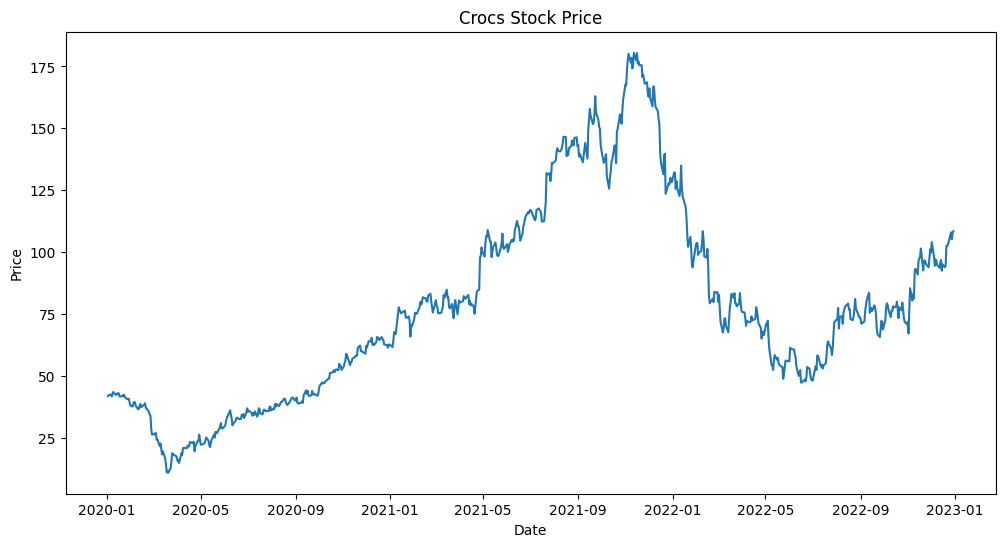

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(crox_data)
plt.title("Crocs Stock Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

Step 4: Check time series for Stationarity and perform differencing if p > 0.05

In [5]:
result = adfuller(crox_data)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.0949427624580028
p-value: 0.717084453486418


In [6]:
#Apply differencing
diff_crox_data = crox_data.diff()

#Get rid of NA values
diff_crox_data = diff_crox_data.dropna()

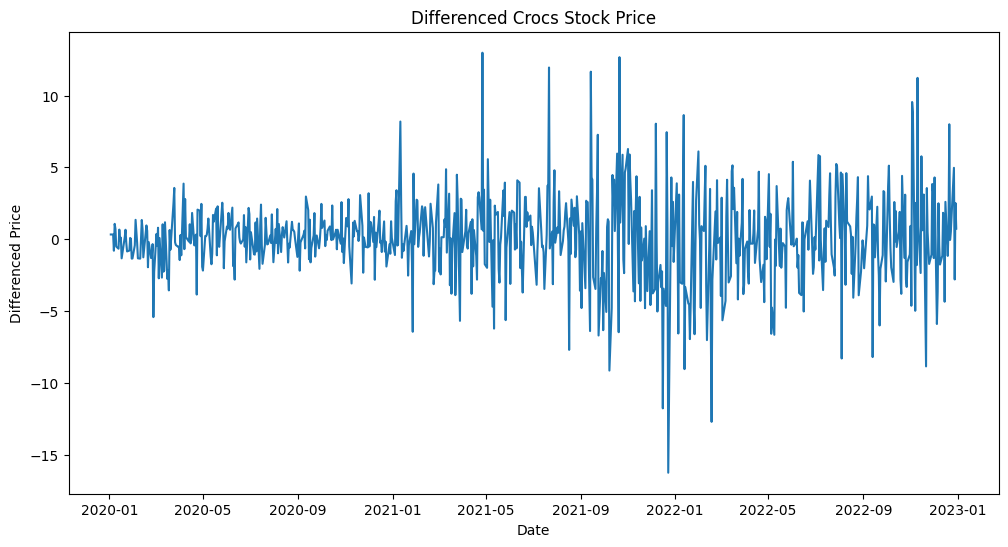

In [7]:
#Visualize the differencing 
plt.figure(figsize=(12, 6))
plt.plot(diff_crox_data)
plt.title("Differenced Crocs Stock Price")
plt.xlabel("Date")
plt.ylabel("Differenced Price")
plt.show()

Step 5: Plot ACF and PACF

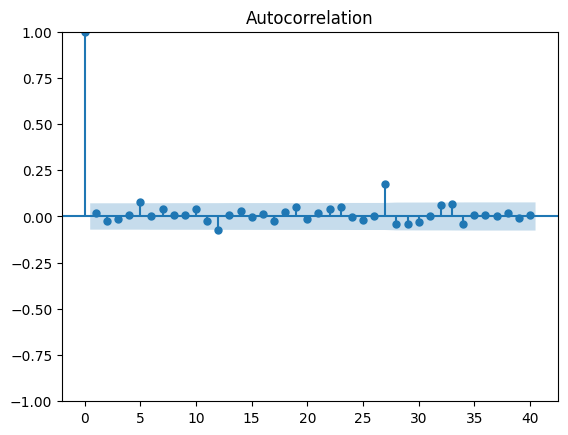

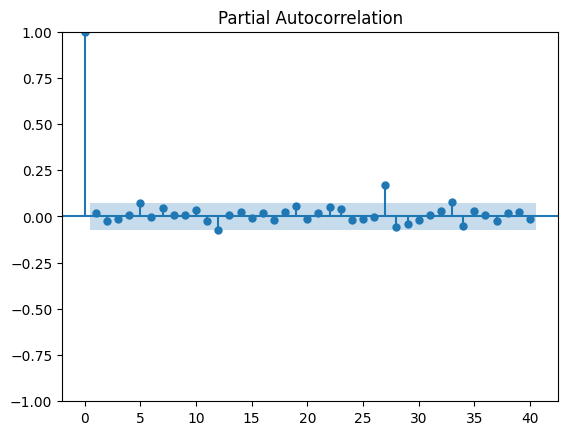

In [8]:
plot_acf(diff_crox_data, lags = 40)
plt.show()

plot_pacf(diff_crox_data, lags = 40)
plt.show()

Step 6: Check for time series frequency and create one if missing

In [9]:
#Check the frequency
print(diff_crox_data.index.freq)

None


In [10]:
#Set the frequency to days
diff_crox_data = diff_crox_data.asfreq('D')
print(diff_crox_data.index.freq)

<Day>


Step 7: Check for missing values and forward fill them if found

In [11]:
#Get how many missing values there are
diff_crox_data.isna().sum()

Ticker
CROX    338
dtype: int64

In [12]:
#Forward fill
diff_crox_data = diff_crox_data.ffill()
diff_crox_data.isna().sum()

Ticker
CROX    0
dtype: int64

Step 8: Divide Data set into Training and Testing Sets

In [13]:
train = diff_crox_data.iloc[:-20]
test = diff_crox_data.iloc[-20:]

Step 9a: Fit the SARIMA Model with (p,d,q) = (1,1,1) and (P,D,Q,s) = (1,1,1,12), where s=12 indicates annual seasonality (12 months in a year) 

In [15]:
# Fit the SARIMA model
sarima_model = SARIMAX(train,
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fit the model to the training data
sarima_result = sarima_model.fit(disp=False)


Step 9b: Fit the Holt-Winters Exponential Smoothing model

In [17]:
hw_model = ExponentialSmoothing(train, 
                                trend='add',   # Additive trend
                                seasonal='add',  # Additive seasonality
                                seasonal_periods=12)  # Assuming monthly seasonality with 12 periods
hw_result = hw_model.fit()

Step 10: For both models, forecast using test set

In [19]:
#Forecast using sarima model
sarima_forecast = sarima_result.forecast(steps=len(test))
print(sarima_forecast)

2022-12-11 00:00:00+00:00    0.082851
2022-12-12 00:00:00+00:00    0.281147
2022-12-13 00:00:00+00:00    0.185916
2022-12-14 00:00:00+00:00    0.415197
2022-12-15 00:00:00+00:00    0.579534
2022-12-16 00:00:00+00:00    0.845423
2022-12-17 00:00:00+00:00    0.716292
2022-12-18 00:00:00+00:00    0.456837
2022-12-19 00:00:00+00:00    0.122143
2022-12-20 00:00:00+00:00    0.642719
2022-12-21 00:00:00+00:00    0.598215
2022-12-22 00:00:00+00:00    0.609463
2022-12-23 00:00:00+00:00    0.743088
2022-12-24 00:00:00+00:00    0.470524
2022-12-25 00:00:00+00:00    0.245578
2022-12-26 00:00:00+00:00    0.439127
2022-12-27 00:00:00+00:00    0.593620
2022-12-28 00:00:00+00:00    0.856796
2022-12-29 00:00:00+00:00    0.726917
2022-12-30 00:00:00+00:00    0.467257
Freq: D, Name: predicted_mean, dtype: float64


In [ ]:
#Forecast using Holt-Winters model

In [20]:
hw_forecast = hw_result.forecast(steps=len(test))
print(hw_forecast)

2022-12-11 00:00:00+00:00    0.454498
2022-12-12 00:00:00+00:00    0.176625
2022-12-13 00:00:00+00:00   -0.049726
2022-12-14 00:00:00+00:00    0.143469
2022-12-15 00:00:00+00:00    0.297799
2022-12-16 00:00:00+00:00    0.560946
2022-12-17 00:00:00+00:00    0.431057
2022-12-18 00:00:00+00:00    0.177328
2022-12-19 00:00:00+00:00   -0.163913
2022-12-20 00:00:00+00:00    0.354904
2022-12-21 00:00:00+00:00    0.309833
2022-12-22 00:00:00+00:00    0.321014
2022-12-23 00:00:00+00:00    0.458586
2022-12-24 00:00:00+00:00    0.180713
2022-12-25 00:00:00+00:00   -0.045637
2022-12-26 00:00:00+00:00    0.147557
2022-12-27 00:00:00+00:00    0.301888
2022-12-28 00:00:00+00:00    0.565035
2022-12-29 00:00:00+00:00    0.435145
2022-12-30 00:00:00+00:00    0.181417
Freq: D, dtype: float64


Step 11: For both models, visualize the forecast

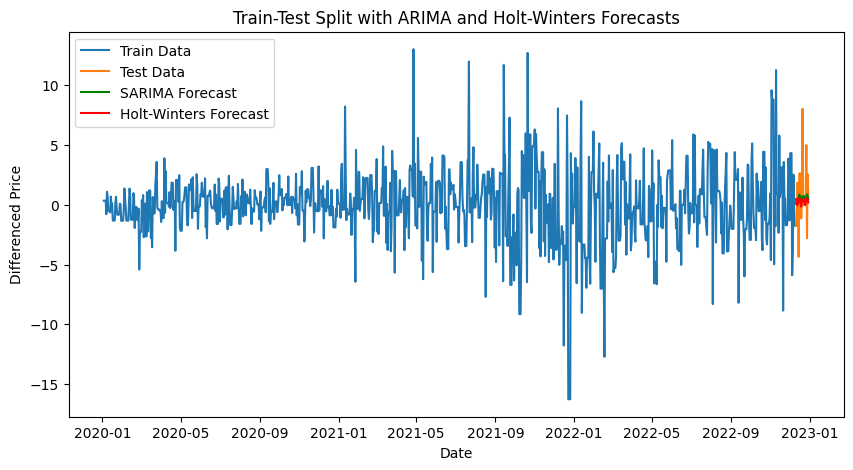

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train Data')
plt.plot(test.index, test, label='Test Data')
plt.plot(sarima_forecast.index,sarima_forecast, label='SARIMA Forecast', color='green')
plt.plot(hw_forecast.index, hw_forecast, label='Holt-Winters Forecast', color='red')
plt.title("Train-Test Split with ARIMA and Holt-Winters Forecasts")
plt.xlabel("Date")
plt.ylabel("Differenced Price")
plt.legend()
plt.show()

Step 12: Evaluate models forecast accuracy

In [25]:
#MAE for SARIMA
sarima_mae = mean_absolute_error(test, sarima_forecast)
#RMSE for SARIMA
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))

#Print MAE or RMSE
print(f"SARIMA MAE: {sarima_mae}")
print(f"SARIMA RMSE: {sarima_rmse}")

SARIMA MAE: 1.832071087272756
SARIMA RMSE: 2.6197867617194364


In [26]:
#MAE for Holt-Winters
hw_mae = mean_absolute_error(test, hw_forecast)
#RMSE for Holt-Winters
hw_rmse = np.sqrt(mean_squared_error(test, hw_forecast))

#Print MAE or RMSE
print(f"Holt-Winters MAE: {hw_mae}")
print(f"Holt-Winters RMSE: {hw_rmse}")

Holt-Winters MAE: 1.9666802011971072
Holt-Winters RMSE: 2.707831450225497


Quick Comparison:
Both SARIMA and Holt-Winters perform similarly but SARIMA is slightly better. The SARIMA model has a lower MAE and RMSE, meaning the SARIMA forecast is closer to the actual values and handles larger errors better.